## Laboratório 2: Algoritmo de Grover

In [27]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, execute
from qiskit.visualization import plot_histogram

import numpy as np

### 1. Qiskit

#### 1.1 - Inicializando Circuitos

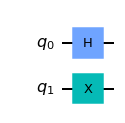

In [2]:
# A. Quantum Circuit
qca = QuantumCircuit(2)

qca.h([0])
qca.x([1])

qca.draw('mpl')

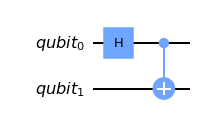

In [3]:
# B. Quantum Register
qrb = QuantumRegister(2, name='qubit')
qcb = QuantumCircuit(qrb)

qcb.h(qrb[0])
qcb.cx(qrb[0], qrb[1])

qcb.draw('mpl')

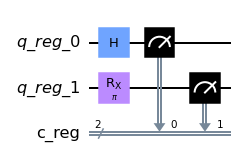

In [4]:
# C. Quantum Register + Classical Register
qrc = QuantumRegister(2, name='q_reg')
crc = ClassicalRegister(2, name='c_reg')
qcc = QuantumCircuit(qrc, crc)

qcc.h(qrc[0])
qcc.rx(np.pi,qrc[1])
qcc.measure(qrc, crc)

qcc.draw('mpl')

#### 1.2 - Simuladores

In [5]:
# A. Backends
display(Aer.backends())

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

Vetor:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Dicionário:
 {'00': 0.5, '11': 0.5}


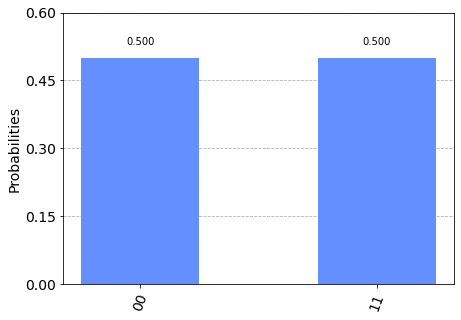

In [35]:
# B. statevector_simulator
qc_state = QuantumCircuit(2)
qc_state.h([0])
qc_state.cx([0],[1])

simulator = Aer.get_backend('statevector_simulator')

result_state_v = execute(qc_state, simulator).result().get_statevector()
result_state_d = execute(qc_state, simulator).result().get_counts()

print('Vetor:\n', result_state_v)
print('Dicionário:\n', result_state_d)

plot_histogram(result_state_d)

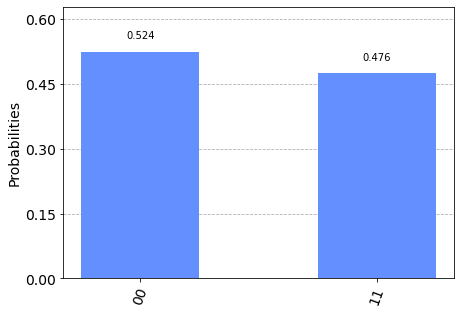

In [33]:
# C. qasm_simulator 
qc_qasm = QuantumCircuit(2,2)
qc_qasm.h([0])
qc_qasm.cx([0], [1])
qc_qasm.measure([0,1], [0,1])

simulator = Aer.get_backend('qasm_simulator')
result_qasm = execute(qc_qasm, simulator, shots = 1024).result().get_counts()

plot_histogram(result_qasm)

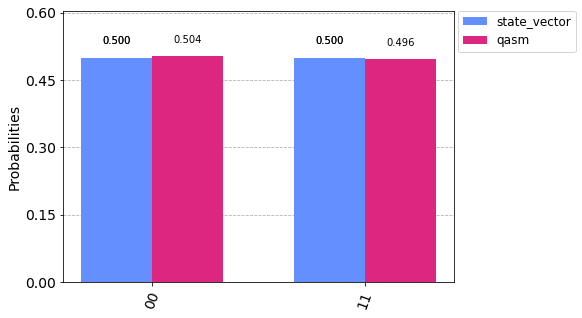

In [8]:
plot_histogram([result_state_d, result_qasm], legend = ['state_vector', 'qasm'])

In [40]:
# D. aer_simulator_unitary
qc_unitary = QuantumCircuit(2)
qc_unitary.h([0,1])

simulator = Aer.get_backend('unitary_simulator')
result_unitary = execute(qc_unitary, simulator).result().get_unitary()

display(result_unitary.round(2))

array([[ 0.5+0.j,  0.5-0.j,  0.5-0.j,  0.5-0.j],
       [ 0.5+0.j, -0.5+0.j,  0.5-0.j, -0.5+0.j],
       [ 0.5+0.j,  0.5-0.j, -0.5+0.j, -0.5+0.j],
       [ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5-0.j]])

#### 1.3 - Investigando Circuitos + Transpile

In [79]:
# A. Gerando Circuitos Aleatórios
from qiskit.circuit.random import random_circuit

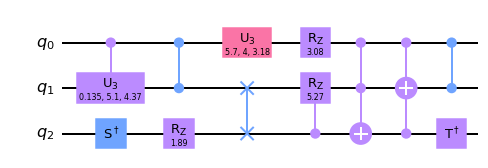

In [80]:
qc_random = random_circuit(3, 7)
qc_random.draw(output='mpl')

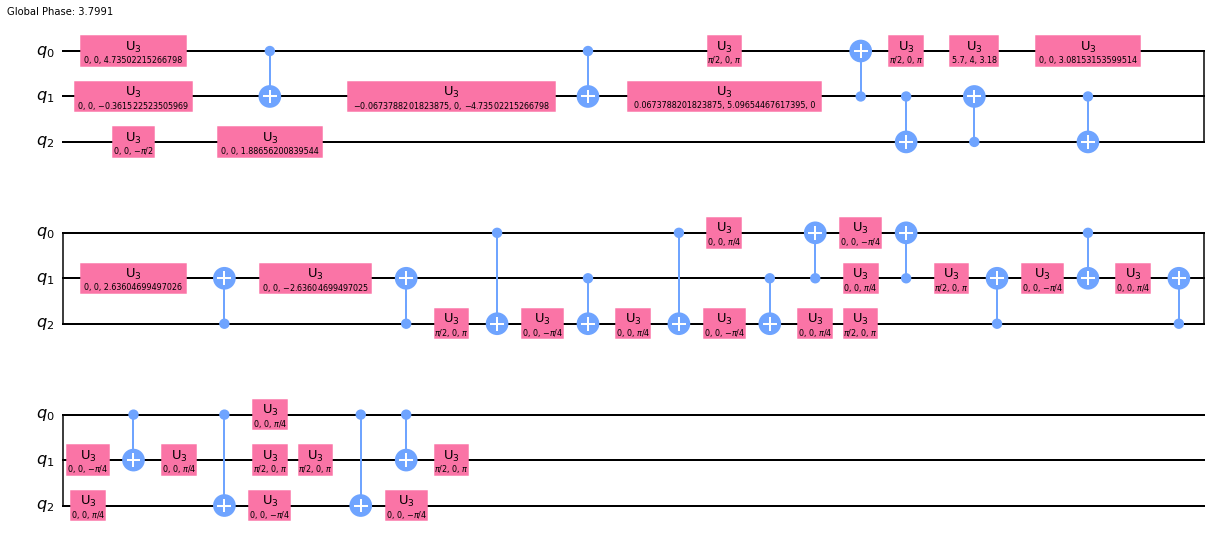

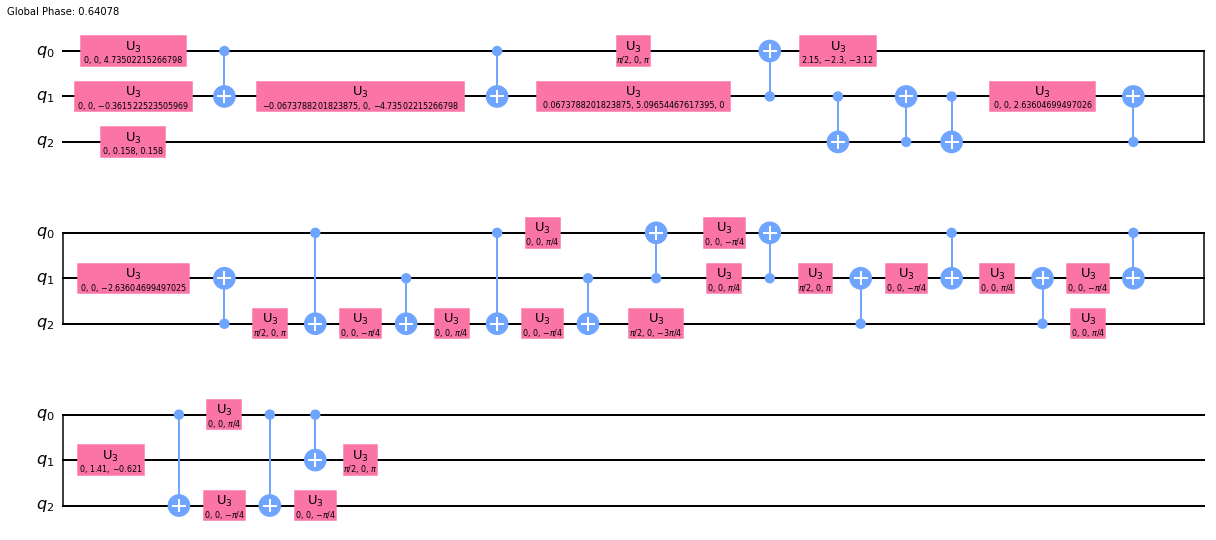

In [81]:
# B. Transpile and Optimization Level
qc_random_transpile_0 = transpile(qc_random, basis_gates=['cx', 'u3'], optimization_level=0)
qc_random_transpile_1 = transpile(qc_random, basis_gates=['cx', 'u3'], optimization_level=1)

display(qc_random_transpile_0.draw('mpl'))
display(qc_random_transpile_1.draw('mpl'))

In [82]:
# C. Contagem de Operações
print(qc_random_transpile_0.count_ops())
print(qc_random_transpile_1.count_ops())

OrderedDict([('u3', 33), ('cx', 21)])
OrderedDict([('u3', 27), ('cx', 21)])


### 2. Algoritmo de Grover

#### 1 - Superposição

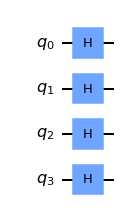

In [200]:
nq = 4

qc_super = QuantumCircuit(nq)
qc_super.h(range(nq))

qc_super.draw('mpl')

#### 2 - Oráculo

In [201]:
def OracleCircuit(marked_list, number_of_qubits):
    oracle_list = np.array([1]*(2**nq))
    oracle_list[marked_list] = -1
    oracle_list = list(oracle_list)
    
    
    qreg = QuantumRegister(number_of_qubits)
    qc_oracle = QuantumCircuit(qreg,name='Grover Oracle')
    qc_oracle.diagonal(oracle_list,qreg)
    return qc_oracle

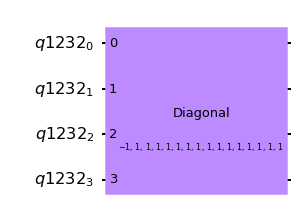

In [202]:
M = [0]

qc_oracle = OracleCircuit(M, nq)
qc_oracle.draw('mpl')

#### 2.3 - Operador de Difusão

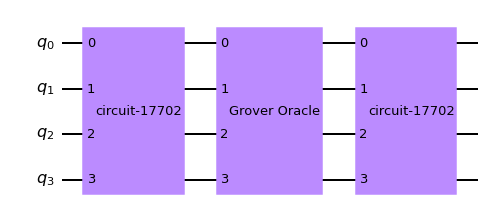

In [203]:
qc_dif = QuantumCircuit(nq)

qc_dif.append(qc_super, range(nq))
qc_dif.append(OracleCircuit([0],nq), range(nq))
qc_dif.append(qc_super, range(nq))


qc_dif.draw('mpl')

#### 2.4 - Circuito Algoritmo de Grover

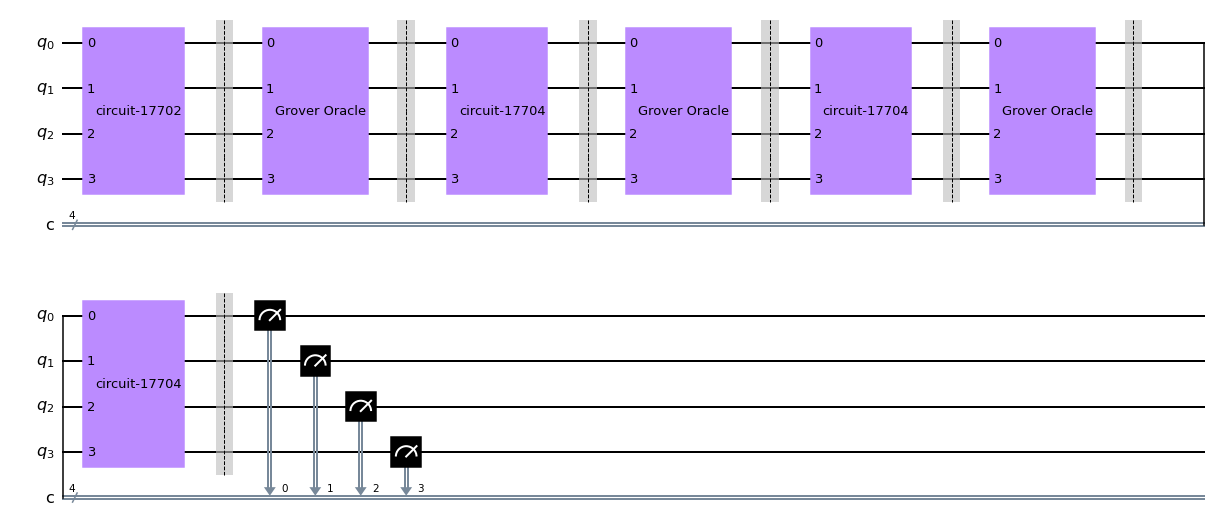

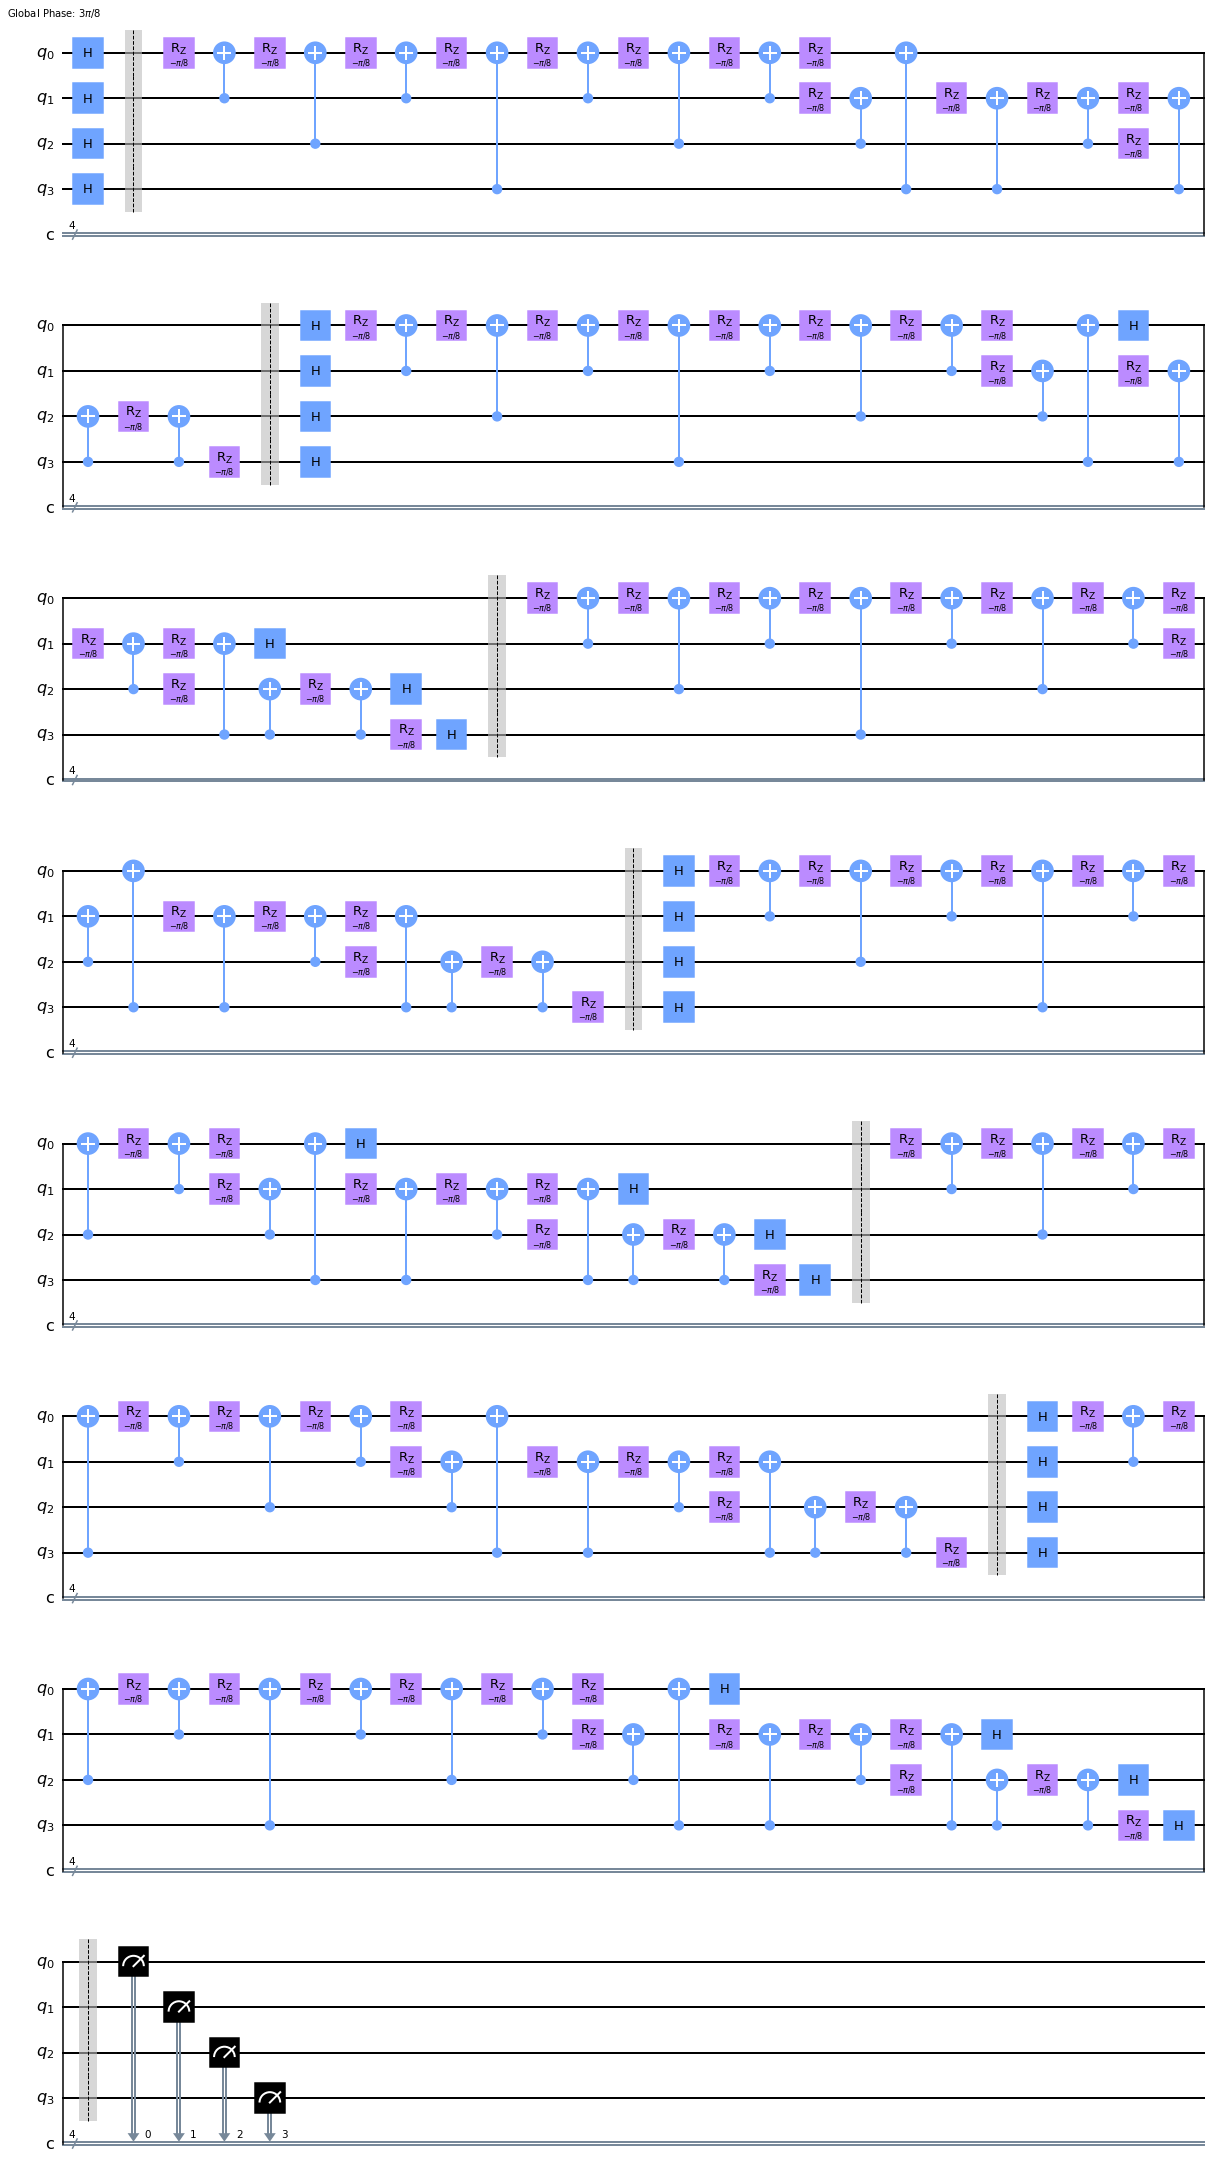

In [206]:
steps = 3
qc_grover = QuantumCircuit(nq,nq)

qc_grover.append(qc_super, range(nq))
qc_grover.barrier()

for t in range(steps):
    qc_grover.append(qc_oracle, range(nq))
    qc_grover.barrier()
    qc_grover.append(qc_dif, range(nq))
    qc_grover.barrier()

qc_grover.measure(range(nq), range(nq))

display(qc_grover.draw('mpl'))
qc_grover = transpile(qc_grover, basis_gates=['cx','rz','h'])
display(qc_grover.draw('mpl'))

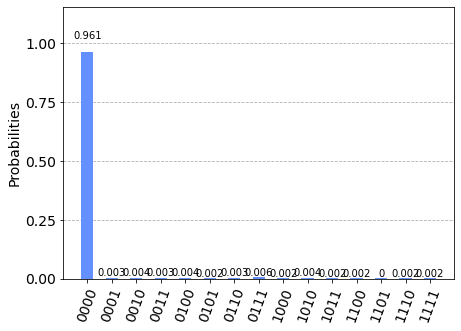

In [207]:
backend = Aer.get_backend('qasm_simulator')
search_result = execute(qc_grover, backend, shots = 1024).result().get_counts()

plot_histogram(search_result)

In [208]:
steps_best = np.floor((np.pi/4)*(np.sqrt(2**nq)))

print(steps_best)

3.0


### 3 - Exercícios

1) Construa uma função que retorne um dos quatro possíveis circuitos para os estados de Bell. Portanto, sua função deverá ter como entrada uma string ('00', '01', '10' ou '11') para saber qual estado de Bell; e deverá ter como saída o circuito quântico para este estado.

2) Baseado no código dado para o Algoritmo de Grover, apresente o plot da probabilidade do elemento marcado para cada passo. Faça para um número suficiente de passos, onde você possa observar que essa probabilidade chega a um máximo, depois decresce, e tem um comportamente oscilatório.

3) Baseado no código dado, construa uma função que retorna um circuito para o algoritmo de Grover generalizado. Portanto, a entrada deverá ser número de qubits (n), uma lista de elementos marcados; e você pode optar por usar o melhor número de passos, dependendo de quantos elementos marcados você tenha, ou dar o número de passos como parâmetro de entrada também.